<a href="https://colab.research.google.com/github/maliozdemir1/dsa210-project-impact-of-climate-on-gastronomic-diversity/blob/main/DataCleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Collection & Cleaning


In [2]:
!pip -q install requests beautifulsoup4 lxml

import re, time
import requests
import pandas as pd
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse, parse_qs

BASE = "https://www.mgm.gov.tr/veridegerlendirme/il-ve-ilceler-istatistik.aspx"

S = requests.Session()
S.headers.update({
    "User-Agent": "Mozilla/5.0",
    "Accept-Language": "tr-TR,tr;q=0.9,en-US;q=0.7,en;q=0.6",
    "Referer": "https://www.mgm.gov.tr/",
})

NUM_RE = re.compile(r"[-+]?\d+(?:[.,]\d+)?")

def to_float(x):
    """Convert a string number that may use comma decimal into float."""
    return float(str(x).strip().replace(",", "."))

def extract_12_from_row(tr):
    """Extract 12 numeric values from a single <tr> row (months)."""
    cells = [c.get_text(" ", strip=True) for c in tr.find_all(["th", "td"])]
    nums = []
    for c in cells:
        found = NUM_RE.findall(c)
        for f in found:
            try:
                nums.append(to_float(f))
            except:
                pass
    return nums[:12] if len(nums) >= 12 else None

def find_row_12vals(soup, label_keywords):
    """
    Find the table row that contains all label_keywords and return its 12 monthly values.
    label_keywords example:
      ["Ortalama Sıcaklık"]
      ["Aylık Toplam Yağış Miktarı", "Ortalaması"]
    """
    for tr in soup.find_all("tr"):
        row_text = tr.get_text(" ", strip=True)
        if all(k in row_text for k in label_keywords):
            vals = extract_12_from_row(tr)
            if vals is not None:
                return vals
    return None

def get_cities_from_ankara_page():
    """
    Collect province links by scanning the ANKARA page for anchors that contain 'm='.
    Returns: [(m_param, display_name), ...]
    """
    r = S.get(BASE, params={"k": "H", "m": "ANKARA"}, timeout=30)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "lxml")

    cities = []
    seen = set()

    # Scan all links; extract m= parameter
    for a in soup.find_all("a", href=True):
        href = a["href"]
        if "m=" not in href:
            continue
        full = urljoin("https://www.mgm.gov.tr", href)
        q = parse_qs(urlparse(full).query)
        m = q.get("m", [None])[0]
        if not m:
            continue

        # Visible province name
        disp = a.get_text(strip=True)

        # Basic filter to avoid unrelated links
        if not disp or len(disp) > 25:
            continue

        key = (m, disp)
        if key not in seen:
            seen.add(key)
            cities.append(key)

    # Fallback: if nothing found, regex-scan the HTML for k=H&m= links
    if len(cities) == 0:
        html = r.text
        ms = re.findall(
            r"il-ve-ilceler-istatistik\.aspx\?k=H(?:&amp;|&)m=([A-Za-zÇĞİÖŞÜçğıöşü0-9]+)",
            html
        )
        ms = list(dict.fromkeys(ms))  # unique preserving order
        cities = [(m, m) for m in ms]

    return cities

def scrape_city(m_param, disp_name=None):
    """
    Scrape one province page:
    - 12 monthly average temperatures
    - 12 monthly total precipitation averages
    plus computed annual metrics.
    """
    r = S.get(BASE, params={"k": "H", "m": m_param}, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"HTTP {r.status_code}")

    soup = BeautifulSoup(r.text, "lxml")

    temp12 = find_row_12vals(soup, ["Ortalama Sıcaklık"])
    prec12 = find_row_12vals(soup, ["Aylık Toplam Yağış Miktarı", "Ortalaması"])

    if temp12 is None or prec12 is None:
        raise ValueError("Could not find the 12-month temperature/precipitation rows in the table.")

    row = {
        "province": disp_name if disp_name else m_param,
        "m_param": m_param,
        "temp_annual_mean": sum(temp12) / 12.0,
        "prec_annual_total": sum(prec12),
    }

    for i, v in enumerate(temp12, start=1):
        row[f"temp_m{i:02d}"] = v

    for i, v in enumerate(prec12, start=1):
        row[f"prec_m{i:02d}"] = v

    return row

# =========================
# RUN FOR ALL PROVINCES
# =========================
cities = get_cities_from_ankara_page()
print("Number of province links found:", len(cities))
print("First 20:", cities[:20])

if len(cities) == 0:
    raise RuntimeError("Could not find the province list. The page structure may have changed.")

rows = []
failed = []

for idx, (m_param, disp) in enumerate(cities, start=1):
    try:
        rows.append(scrape_city(m_param, disp))
    except Exception as e:
        failed.append({"m_param": m_param, "display": disp, "error": str(e)})

    time.sleep(0.6)  # be polite with rate-limiting

print("Success:", len(rows), "| Failed:", len(failed))

if rows:
    out = pd.DataFrame(rows).sort_values("province").reset_index(drop=True)
    out.to_csv("iklim_mgm_1991_2020.csv", index=False, encoding="utf-8-sig")

    print("✅ Saved: iklim_mgm_1991_2020.csv")
    # --- Preview the generated CSV in the notebook ---
    print("\n=== Preview: iklim_mgm_1991_2020.csv ===")
    print("Shape:", out.shape)
    display(out.head(10))          # first 10 rows

    print("\nColumns:", list(out.columns))
    display(out.tail(5))           # last 5 rows (optional)

    # Quick sanity checks
    print("\nMissing values (top):")
    display(out.isna().sum().sort_values(ascending=False).head(10))

    print("\nBasic stats:")
    display(out[["temp_annual_mean", "prec_annual_total"]].describe())


if failed:
    pd.DataFrame(failed).to_csv("iklim_failed.csv", index=False, encoding="utf-8-sig")
    print("Saved: iklim_failed.csv")
    display(pd.DataFrame(failed).head(15))


Number of province links found: 83
First 20: [('BAKU', 'Bakü Tahmini'), ('SARAYBOSNA', 'Saraybosna Tahmini'), ('ADANA', 'Adana'), ('ADIYAMAN', 'Adıyaman'), ('AFYONKARAHISAR', 'Afyonkarahisar'), ('AGRI', 'Ağrı'), ('AKSARAY', 'Aksaray'), ('AMASYA', 'Amasya'), ('ANKARA', 'Ankara'), ('ANTALYA', 'Antalya'), ('ARDAHAN', 'Ardahan'), ('ARTVIN', 'Artvin'), ('AYDIN', 'Aydın'), ('BALIKESIR', 'Balıkesir'), ('BARTIN', 'Bartın'), ('BATMAN', 'Batman'), ('BAYBURT', 'Bayburt'), ('BILECIK', 'Bilecik'), ('BINGOL', 'Bingöl'), ('BITLIS', 'Bitlis')]
✅ Success: 79 | ❌ Failed: 4
✅ Saved: iklim_mgm_1991_2020.csv

=== Preview: iklim_mgm_1991_2020.csv ===
Shape: (79, 28)


,province,m_param,temp_annual_mean,prec_annual_total,temp_m01,temp_m02,temp_m03,temp_m04,temp_m05,temp_m06,...,prec_m03,prec_m04,prec_m05,prec_m06,prec_m07,prec_m08,prec_m09,prec_m10,prec_m11,prec_m12
0,Adana,ADANA,19.458333,680.8,9.5,10.7,13.9,17.7,22.1,25.9,...,59.2,51.2,48.2,20.3,12.3,10.4,25.1,39.7,78.4,143.0
1,Adıyaman,ADIYAMAN,17.683333,729.5,5.0,6.2,10.4,15.3,20.9,27.1,...,87.3,61.7,45.2,9.4,1.9,2.5,9.2,48.6,74.1,142.0
2,Afyonkarahisar,AFYONKARAHISAR,11.691667,451.4,0.4,2.2,6.0,10.5,15.3,19.4,...,44.6,47.0,50.1,41.5,21.8,18.0,23.6,40.3,32.4,46.8
3,Aksaray,AKSARAY,12.775000,349.4,0.9,2.6,7.1,11.9,16.7,21.0,...,39.7,40.4,43.1,24.7,8.2,6.2,12.4,25.9,30.1,44.8
4,Amasya,AMASYA,13.791667,469.2,2.8,4.6,8.5,13.3,17.8,21.6,...,50.2,51.9,61.3,41.0,12.9,12.9,21.3,36.4,44.6,53.8
5,Ankara,ANKARA,12.583333,413.6,0.9,2.7,6.7,11.5,16.5,20.6,...,46.9,44.5,51.0,40.2,14.8,14.6,17.9,33.4,31.9,43.2
6,Antalya,ANTALYA,18.983333,1059.4,9.8,10.8,13.1,16.4,20.9,25.7,...,94.5,63.1,37.0,10.1,4.0,5.0,22.0,76.6,152.1,271.7
7,Ardahan,ARDAHAN,4.275000,600.4,-10.3,-9.1,-2.3,4.7,9.6,13.3,...,37.0,54.2,85.2,101.7,77.2,64.8,38.9,41.1,29.9,24.7
8,Artvin,ARTVIN,12.500000,724.6,2.8,3.9,7.2,11.7,15.9,19.1,...,63.8,52.2,57.3,51.5,36.9,33.1,40.9,67.0,81.4,83.8
9,Aydın,AYDIN,18.050000,653.5,8.2,9.5,12.3,16.1,21.2,26.2,...,70.8,53.4,43.8,14.3,6.0,6.1,18.4,45.2,86.5,110.3



Columns: ['province', 'm_param', 'temp_annual_mean', 'prec_annual_total', 'temp_m01', 'temp_m02', 'temp_m03', 'temp_m04', 'temp_m05', 'temp_m06', 'temp_m07', 'temp_m08', 'temp_m09', 'temp_m10', 'temp_m11', 'temp_m12', 'prec_m01', 'prec_m02', 'prec_m03', 'prec_m04', 'prec_m05', 'prec_m06', 'prec_m07', 'prec_m08', 'prec_m09', 'prec_m10', 'prec_m11', 'prec_m12']


,province,m_param,temp_annual_mean,prec_annual_total,temp_m01,temp_m02,temp_m03,temp_m04,temp_m05,temp_m06,...,prec_m03,prec_m04,prec_m05,prec_m06,prec_m07,prec_m08,prec_m09,prec_m10,prec_m11,prec_m12
74,Çankırı,CANKIRI,11.575000,427.9,-0.4,1.5,6.0,11.0,15.9,20.1,...,38.1,45.2,57.8,45.5,20.4,22.9,20.0,32.5,26.3,45.9
75,Çorum,CORUM,11.000000,448.8,-0.2,1.4,5.6,10.4,15.0,18.7,...,42.0,46.6,61.7,63.5,21.4,19.0,24.9,27.9,32.9,43.0
76,İzmir,IZMIR,18.358333,730.5,9.0,9.9,12.4,16.2,21.1,26.0,...,77.8,50.1,32.9,14.4,3.0,6.7,23.5,56.5,99.6,131.3
77,Şanlıurfa,SANLIURFA,19.008333,450.5,6.2,7.5,11.8,16.8,22.8,28.8,...,57.9,44.7,26.2,5.8,2.0,4.0,8.1,24.6,51.2,78.7
78,Şırnak,SIRNAK,15.608333,768.2,2.6,3.8,8.1,12.5,18.7,25.3,...,125.8,115.1,52.6,5.3,6.1,0.7,13.2,54.6,82.5,101.2



Missing values (top):


,0
province,0
m_param,0
temp_annual_mean,0
prec_annual_total,0
temp_m01,0
temp_m02,0
temp_m03,0
temp_m04,0
temp_m05,0
temp_m06,0



Basic stats:


,temp_annual_mean,prec_annual_total
count,79.000000,79.000000
mean,13.470992,644.887342
std,3.284638,300.432114
min,4.275000,265.800000
25%,11.550000,449.650000
50%,13.491667,573.800000
75%,15.362500,739.700000
max,20.150000,2309.500000


⚠️ Saved: iklim_failed.csv


,m_param,display,error
0,BAKU,Bakü Tahmini,Could not find the 12-month temperature/precip...
1,SARAYBOSNA,Saraybosna Tahmini,Could not find the 12-month temperature/precip...
2,ISTANBUL,İstanbul,Could not find the 12-month temperature/precip...
3,KAHRAMANMARAS,Kahramanmaraş,Could not find the 12-month temperature/precip...


This code is for web scraping of province-level climate data from MGM's website, by automatically visiting each page of a province and getting the monthly average temperature and monthly total precipitation averages of the 1991-2020 period.

By using these monthly values, annual mean temperature and annual total precipitation are calculated. Then, the final dataset is saved as a CSV file, whereas provinces that fail during scraping are logged separately.



In [29]:
import pandas as pd
import numpy as np
import openpyxl

TP_CSV = "TurkPatent_all_with_other.csv"
FOODS_XLSX = "yiyecekler.xlsx"

OUT_LIST_CSV  = "TurkPatent_ALL_kcal_list.csv"
OUT_LIST_XLSX = "TurkPatent_ALL_kcal_list.xlsx"
OUT_GROUP_SUMMARY = "kcal_group_summary.csv"

def norm(s):
    return str(s).strip().lower()

# 1) Read TurkPatent
tp = pd.read_csv(TP_CSV, sep=";", encoding="utf-8-sig")

# 2) Read calorie samples from Excel (ALL sheets)
wb = openpyxl.load_workbook(FOODS_XLSX, read_only=True, data_only=True)
sheet_names = wb.sheetnames

samples = []
for sh in sheet_names:
    df = pd.read_excel(FOODS_XLSX, sheet_name=sh)
    if df.shape[1] < 2:
        continue

    # IMPORTANT: group name = first column HEADER (not the sheet name)
    group_name = norm(df.columns[0])

    # first two columns: [sample_food, kcal]
    sample_col = df.columns[0]
    kcal_col   = df.columns[1]

    tmp = df[[sample_col, kcal_col]].copy()
    tmp.columns = ["sample_food", "kcal_100g"]

    tmp["kcal_group"] = group_name
    tmp["sample_food"] = tmp["sample_food"].astype(str).str.strip()
    tmp["kcal_100g"] = pd.to_numeric(tmp["kcal_100g"], errors="coerce")

    tmp = tmp.dropna(subset=["sample_food", "kcal_100g"])
    tmp = tmp[tmp["sample_food"].str.lower().ne("nan")]

    samples.append(tmp)

samples_df = pd.concat(samples, ignore_index=True)

print("Extracted sample rows:", len(samples_df))
print("Unique kcal_group extracted:", samples_df["kcal_group"].nunique())
print("kcal_group list:", sorted(samples_df["kcal_group"].unique()))

# 3) Group summary
grp = (samples_df.groupby("kcal_group")
       .agg(n_samples=("kcal_100g","size"),
            mean_kcal=("kcal_100g","mean"),
            median_kcal=("kcal_100g","median"),
            std_kcal=("kcal_100g","std"))
       .reset_index())

grp.to_csv(OUT_GROUP_SUMMARY, index=False, encoding="utf-8-sig")

# 4) TurkPatent group -> kcal_group mapping
tp_to_kcal_group = {
    "Yemekler ve çorbalar": "yemekler ve çorbalar",
    "Yiyecekler için çeşni / lezzet vericiler, soslar ve tuz": "yiyecekler için çeşni",
    "Peynirler": "peynir",
    "Peynirler ve tereyağı dışında kalan süt ürünleri": "süt ürünleri",
    "İşlenmiş ve işlenmemiş meyve ve sebzeler ile mantarlar": "sebze ve meyve",
    "İşlenmiş ve işlenmemiş et ürünleri": "işlenmiş et",
    "Fırıncılık ve pastacılık mamulleri, hamur işleri, tatlılar": "hamurişi tatlı",
    "Dondurmalar ve yenilebilir buzlar": "dondurmalar",
    "Alkolsüz içecekler": "soft içecekler",
    "Bal": "bal",
    "Biralar ve diğer alkollü içkiler": "alkoller",
    "Çikolata, şekerleme ve türevi ürünler": "çikolata/şeker",
    "Diğer ürünler": "diğer",
}

map_df = pd.DataFrame({
    "Ürün Grubu": list(tp_to_kcal_group.keys()),
    "kcal_group": [norm(v) for v in tp_to_kcal_group.values()]
})

# Attach kcal stats
map_df = map_df.merge(grp, on="kcal_group", how="left")

# DEBUG: show which mappings didn't find any stats
missing = map_df[map_df["mean_kcal"].isna()][["Ürün Grubu","kcal_group"]]
if len(missing) > 0:
    print("\nThese mapped kcal_group names were NOT found in Excel groups:")
    print(missing.to_string(index=False))
    print("\nAvailable Excel kcal_group names:")
    print(sorted(grp["kcal_group"].unique()))

# 5) Assign calories to TurkPatent
tp2 = tp.merge(
    map_df[["Ürün Grubu","kcal_group","mean_kcal","median_kcal","n_samples","std_kcal"]],
    on="Ürün Grubu",
    how="left"
)

tp2 = tp2.rename(columns={
    "Coğrafi İşaretin Adı": "food_name",
    "İl": "province",
    "Ürün Grubu": "tp_group"
})

tp2["kcal_100g"] = tp2["mean_kcal"]
mask = tp2["kcal_100g"].isna()
tp2.loc[mask, "kcal_100g"] = tp2.loc[mask, "median_kcal"]

# 6) Export final list
final_cols = ["food_name","province","tp_group","kcal_group","kcal_100g","n_samples","std_kcal"]
final = tp2[final_cols].copy()

final.to_csv(OUT_LIST_CSV, index=False, encoding="utf-8-sig")
final.to_excel(OUT_LIST_XLSX, index=False)

print("\nOutputs created:")
print("-", OUT_LIST_CSV)
print("-", OUT_LIST_XLSX)
print("-", OUT_GROUP_SUMMARY)
print("Total rows:", len(final))
print("Rows with kcal:", final["kcal_100g"].notna().sum())


Extracted sample rows: 131
Unique kcal_group extracted: 14
kcal_group list: ['alkoller', 'bal', 'diğer', 'dondurmalar', 'hamurişi tatlı', 'işlenmiş et', 'peynir', 'sebze ve meyve', 'soft içecekler', 'süt ürünleri', 'tereyağı ve sıvıyağlar', 'yemekler ve çorbalar', 'yiyecekler için çeşni', 'çikolata/şeker']

✅ Outputs created:
- TurkPatent_ALL_kcal_list.csv
- TurkPatent_ALL_kcal_list.xlsx
- kcal_group_summary.csv
Total rows: 1514
Rows with kcal: 1514


This code provides an estimated value for kcal/100g for any food from the TurkPatent GI database. The estimated value is arrived at by utilizing calorie samples from an Excel file which contains calories of the food. The script will read all sheets from the Excel workbook, create groups of calorie samples (based on the First column name from each sheet), generate statistics for calorie groups (mean/median/std), match TurkPatent groups with the groups of calorie samples, append the statistics to the TurkPatent dataframe, and finally generate a list of estimated food-level kcal.

In [1]:
import pandas as pd
import numpy as np
import re

# ==========
# INPUT / OUTPUT
# ==========
MAPPED_PATH = "TurkPatent_ALL_kcal_list.csv"   # your mean-mapped output
OUT_MAPPED  = "mean_mapped_clean_en.csv"

# ==========
# Helpers
# ==========
TR_LOWER_MAP = str.maketrans({"I":"ı","İ":"i"})
TR_UPPER_MAP = str.maketrans({"i":"İ","ı":"I"})

def tr_title(s: str):
    if pd.isna(s):
        return np.nan
    s = re.sub(r"\s+", " ", str(s).strip())
    if not s:
        return s
    s_low = s.translate(TR_LOWER_MAP).lower()
    parts = []
    for w in s_low.split(" "):
        if not w:
            continue
        parts.append(w[0].translate(TR_UPPER_MAP).upper() + w[1:])
    return " ".join(parts)

def clean_text(s):
    if pd.isna(s):
        return np.nan
    return re.sub(r"\s+", " ", str(s).strip())

# Optional: TR -> EN group names (nice for reporting)
GROUP_TR_TO_EN = {
    "Yemekler ve çorbalar": "Meals & soups",
    "Yiyecekler için çeşni / lezzet vericiler, soslar ve tuz": "Seasonings, sauces & salt",
    "Peynirler": "Cheese",
    "Peynirler ve tereyağı dışında kalan süt ürünleri": "Dairy (excluding cheese & butter)",
    "İşlenmiş ve işlenmemiş meyve ve sebzeler ile mantarlar": "Fruits, vegetables & mushrooms",
    "İşlenmiş ve işlenmemiş et ürünleri": "Meat products",
    "Fırıncılık ve pastacılık mamulleri, hamur işleri, tatlılar": "Bakery, pastry & desserts",
    "Dondurmalar ve yenilebilir buzlar": "Ice cream & edible ice",
    "Alkolsüz içecekler": "Non-alcoholic beverages",
    "Bal": "Honey",
    "Biralar ve diğer alkollü içkiler": "Alcoholic beverages",
    "Çikolata, şekerleme ve türevi ürünler": "Chocolate & confectionery",
    "Diğer ürünler": "Other products",
}

# ==========
# Load & rename
# ==========
mapped = pd.read_csv(MAPPED_PATH, encoding="utf-8-sig")

# Expect columns: food_name, province, tp_group, kcal_100g, ...
mapped_clean = mapped.rename(columns={
    "tp_group": "product_group_tr",
}).copy()

# ==========
# Clean text + types
# ==========
mapped_clean["province"] = mapped_clean["province"].apply(tr_title)
mapped_clean["food_name"] = mapped_clean["food_name"].apply(clean_text)
mapped_clean["product_group_tr"] = mapped_clean["product_group_tr"].apply(clean_text)
mapped_clean["kcal_100g"] = pd.to_numeric(mapped_clean["kcal_100g"], errors="coerce")

mapped_clean["product_group_en"] = mapped_clean["product_group_tr"].map(GROUP_TR_TO_EN).fillna("Unknown")

# Keep only columns you need
mapped_clean = mapped_clean[["province","food_name","product_group_tr","product_group_en","kcal_100g"]].copy()

# Drop empty essentials, remove duplicates
mapped_clean = mapped_clean.dropna(subset=["province","food_name","product_group_tr"])
mapped_clean = mapped_clean.drop_duplicates(subset=["province","food_name"], keep="first").reset_index(drop=True)

# ==========
# Save
# ==========
mapped_clean.to_csv(OUT_MAPPED, index=False, encoding="utf-8-sig")

print("✅ Saved:", OUT_MAPPED)
print("Rows:", len(mapped_clean))
display(mapped_clean.head(10))



✅ Saved: mean_mapped_clean_en.csv
Rows: 1509


,province,food_name,product_group_tr,product_group_en,kcal_100g
0,Adana,Adana Yer Fıstığı,İşlenmiş ve işlenmemiş meyve ve sebzeler ile m...,"Fruits, vegetables & mushrooms",195.379310
1,Adana,Kuytucak Narı,İşlenmiş ve işlenmemiş meyve ve sebzeler ile m...,"Fruits, vegetables & mushrooms",195.379310
2,Adana,Adana Kol Böreği,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",299.684211
3,Adana,Adana Analı Kızlı,Yemekler ve çorbalar,Meals & soups,211.117647
4,Adana,Adana Aşlama,Alkolsüz içecekler,Non-alcoholic beverages,72.571429
5,Adana,Adana Bici Bici,Dondurmalar ve yenilebilir buzlar,Ice cream & edible ice,145.500000
6,Adana,Adana Halka Tatlısı,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",299.684211
7,Adana,Adana Karakuş Tatlısı,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",299.684211
8,Adana,Adana Karpuzu,İşlenmiş ve işlenmemiş meyve ve sebzeler ile m...,"Fruits, vegetables & mushrooms",195.379310
9,Adana,Adana Kebabı,Yemekler ve çorbalar,Meals & soups,211.117647


With this code, we have gathered the kcal-mapped TurkPatent dataset, cleaned text formatting (Turkish-aware province casing), added English group labels, removed duplicates, and exported a cleaner CSV for analysis/reporting.

In [9]:
import pandas as pd

df = pd.read_csv("mean_mapped_clean_en.csv", encoding="utf-8-sig")
df.head()


,province,food_name,product_group_tr,product_group_en,kcal_100g
0,Adana,Adana Yer Fıstığı,İşlenmiş ve işlenmemiş meyve ve sebzeler ile m...,"Fruits, vegetables & mushrooms",195.379310
1,Adana,Kuytucak Narı,İşlenmiş ve işlenmemiş meyve ve sebzeler ile m...,"Fruits, vegetables & mushrooms",195.379310
2,Adana,Adana Kol Böreği,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",299.684211
3,Adana,Adana Analı Kızlı,Yemekler ve çorbalar,Meals & soups,211.117647
4,Adana,Adana Aşlama,Alkolsüz içecekler,Non-alcoholic beverages,72.571429


In [4]:
import pandas as pd

mapped_clean = pd.read_csv("mean_mapped_clean_en.csv", encoding="utf-8-sig")

summary = (mapped_clean.groupby("product_group_en")["kcal_100g"]
           .agg(
               n_foods="size",
               n_unique="nunique",
               mean_kcal="mean",
               min_kcal="min",
               max_kcal="max"
           )
           .reset_index()
           .sort_values("mean_kcal", ascending=False))

print("Mean-mapped group calories (should be constant within each group):")
display(summary.head(30))


Mean-mapped group calories (should be constant within each group):


,product_group_en,n_foods,n_unique,mean_kcal,min_kcal,max_kcal
4,Dairy (excluding cheese & butter),23,1,398.000000,398.000000,398.000000
3,Chocolate & confectionery,41,1,395.750000,395.750000,395.750000
11,Other products,39,1,356.800000,356.800000,356.800000
2,Cheese,48,1,341.857143,341.857143,341.857143
6,Honey,34,1,326.000000,326.000000,326.000000
1,"Bakery, pastry & desserts",362,1,299.684211,299.684211,299.684211
9,Meat products,31,1,251.875000,251.875000,251.875000
12,"Seasonings, sauces & salt",29,1,211.666667,211.666667,211.666667
8,Meals & soups,497,1,211.117647,211.117647,211.117647
5,"Fruits, vegetables & mushrooms",367,1,195.379310,195.379310,195.379310


In [5]:
proof = summary.copy()
proof["is_constant_within_group"] = (proof["n_unique"] == 1) & (proof["min_kcal"] == proof["max_kcal"])
display(proof[["product_group_en","n_foods","n_unique","mean_kcal","min_kcal","max_kcal","is_constant_within_group"]])


,product_group_en,n_foods,n_unique,mean_kcal,min_kcal,max_kcal,is_constant_within_group
4,Dairy (excluding cheese & butter),23,1,398.000000,398.000000,398.000000,True
3,Chocolate & confectionery,41,1,395.750000,395.750000,395.750000,True
11,Other products,39,1,356.800000,356.800000,356.800000,True
2,Cheese,48,1,341.857143,341.857143,341.857143,True
6,Honey,34,1,326.000000,326.000000,326.000000,True
1,"Bakery, pastry & desserts",362,1,299.684211,299.684211,299.684211,True
9,Meat products,31,1,251.875000,251.875000,251.875000,True
12,"Seasonings, sauces & salt",29,1,211.666667,211.666667,211.666667,True
8,Meals & soups,497,1,211.117647,211.117647,211.117647,True
5,"Fruits, vegetables & mushrooms",367,1,195.379310,195.379310,195.379310,True


In [6]:
grp_std = (mapped_clean.groupby("product_group_en")["kcal_100g"]
           .agg(n="size", std="std", mean="mean")
           .sort_values("std"))

print("Within-group std (mean-mapped):")
display(grp_std.reset_index())


Within-group std (mean-mapped):


,product_group_en,n,std,mean
0,Alcoholic beverages,13,0.0,190.000000
1,"Bakery, pastry & desserts",362,0.0,299.684211
2,Cheese,48,0.0,341.857143
3,Chocolate & confectionery,41,0.0,395.750000
4,Dairy (excluding cheese & butter),23,0.0,398.000000
5,"Fruits, vegetables & mushrooms",367,0.0,195.379310
6,Honey,34,0.0,326.000000
7,Ice cream & edible ice,4,0.0,145.500000
8,Meals & soups,497,0.0,211.117647
9,Meat products,31,0.0,251.875000


/tmp/ipython-input-2158837359.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=top_groups, showfliers=False)


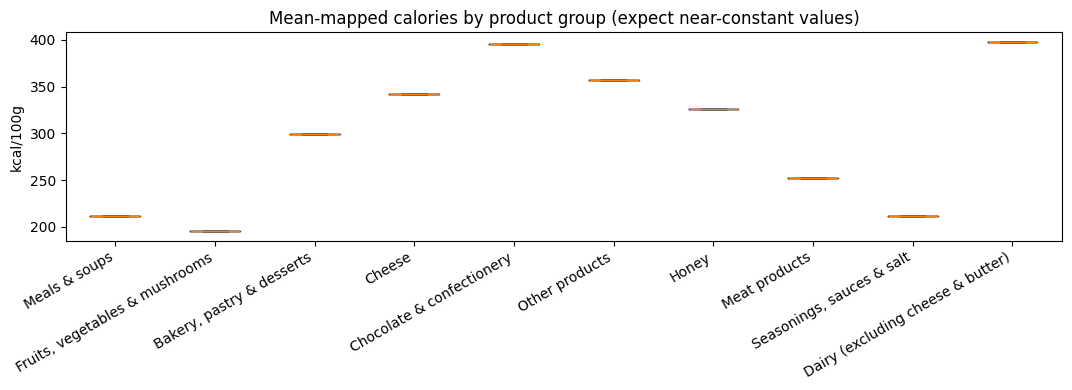

In [7]:
import matplotlib.pyplot as plt

top_groups = mapped_clean["product_group_en"].value_counts().head(10).index.tolist()
data = [mapped_clean.loc[mapped_clean["product_group_en"]==g, "kcal_100g"].dropna().values for g in top_groups]

plt.figure(figsize=(11,4))
plt.boxplot(data, labels=top_groups, showfliers=False)
plt.title("Mean-mapped calories by product group (expect near-constant values)")
plt.ylabel("kcal/100g")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
import numpy as np
import re

MANUAL_PATH = "kaloriler_manual.csv"
OUT_MANUAL  = "manual_clean_en.csv"

TR_LOWER_MAP = str.maketrans({"I":"ı","İ":"i"})
TR_UPPER_MAP = str.maketrans({"i":"İ","ı":"I"})

def tr_title(s: str):
    if pd.isna(s):
        return np.nan
    s = re.sub(r"\s+", " ", str(s).strip())
    if not s:
        return s
    s_low = s.translate(TR_LOWER_MAP).lower()
    parts = []
    for w in s_low.split(" "):
        if not w:
            continue
        parts.append(w[0].translate(TR_UPPER_MAP).upper() + w[1:])
    return " ".join(parts)

def clean_text(s):
    if pd.isna(s):
        return np.nan
    return re.sub(r"\s+", " ", str(s).strip())

GROUP_TR_TO_EN = {
    "Yemekler ve çorbalar": "Meals & soups",
    "Yiyecekler için çeşni / lezzet vericiler, soslar ve tuz": "Seasonings, sauces & salt",
    "Peynirler": "Cheese",
    "Peynirler ve tereyağı dışında kalan süt ürünleri": "Dairy (excluding cheese & butter)",
    "İşlenmiş ve işlenmemiş meyve ve sebzeler ile mantarlar": "Fruits, vegetables & mushrooms",
    "İşlenmiş ve işlenmemiş et ürünleri": "Meat products",
    "Fırıncılık ve pastacılık mamulleri, hamur işleri, tatlılar": "Bakery, pastry & desserts",
    "Dondurmalar ve yenilebilir buzlar": "Ice cream & edible ice",
    "Alkolsüz içecekler": "Non-alcoholic beverages",
    "Bal": "Honey",
    "Biralar ve diğer alkollü içkiler": "Alcoholic beverages",
    "Çikolata, şekerleme ve türevi ürünler": "Chocolate & confectionery",
    "Diğer ürünler": "Other products",
}

manual = pd.read_csv(MANUAL_PATH, encoding="utf-8-sig")

manual_clean = manual.rename(columns={
    "İl": "province",
    "Coğrafi İşaretin Adı": "food_name",
    "Ürün Grubu": "product_group_tr",
    "Kalori": "kcal_100g"
}).copy()

manual_clean["province"] = manual_clean["province"].apply(tr_title)
manual_clean["food_name"] = manual_clean["food_name"].apply(clean_text)
manual_clean["product_group_tr"] = manual_clean["product_group_tr"].apply(clean_text)
manual_clean["kcal_100g"] = pd.to_numeric(manual_clean["kcal_100g"], errors="coerce")

manual_clean["product_group_en"] = manual_clean["product_group_tr"].map(GROUP_TR_TO_EN).fillna("Unknown")

manual_clean = manual_clean.dropna(subset=["province","food_name","product_group_tr","kcal_100g"])
manual_clean = manual_clean.drop_duplicates(subset=["province","food_name"], keep="first").reset_index(drop=True)

manual_clean = manual_clean[["province","food_name","product_group_tr","product_group_en","kcal_100g"]].copy()
manual_clean.to_csv(OUT_MANUAL, index=False, encoding="utf-8-sig")

print("Saved:", OUT_MANUAL)
print("Rows:", len(manual_clean))
display(manual_clean.head(10))


✅ Saved: manual_clean_en.csv
Rows: 1530


,province,food_name,product_group_tr,product_group_en,kcal_100g
0,Adana,Adana Halka Tatlısı,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",320
1,Adana,Adana Karakuş Tatlısı,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",294
2,Adana,Adana Kol Böreği,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",226
3,Adana,Adana Taş Kadayıfı,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",361
4,Sakarya,Adapazarı Kabak Tatlısı,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",290
5,Afyonkarahisar,Afyon Ağzıaçığı,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",290
6,Afyonkarahisar,Afyon Bükmesi,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",363
7,Afyonkarahisar,Afyon Kaymaklı Ekmek Kadayıfı,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",330
8,Afyonkarahisar,Afyonkarahisar Ak Pide / Afyonkarahisar Tırnak...,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",281
9,Afyonkarahisar,Afyonkarahisar Haşhaşlı Katmer,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",321


In here, calorie information that is gathered manually is processed. It removes text information, resolves province names in Turkish, processes calorie information into numeric format, and removes duplicate the incomplete records. The product groups are also given English labels to make it easier to use these data for in other steps.

In [27]:
import pandas as pd

# 1) Read the cleaned output
df = pd.read_csv("manual_clean_en.csv", encoding="utf-8-sig")

print("Cleaned dataset loaded successfully.")
print("Shape (rows, columns):", df.shape)
print("Columns:", list(df.columns))

# 2) Preview
display(df.head(10))

# 3) Quick data quality checks
print("\nMissing values per column:")
display(df.isna().sum().to_frame("missing"))

print("\nTop 10 English product groups (counts):")
display(df["product_group_en"].value_counts().head(10).to_frame("count"))

print("\nBasic kcal statistics:")
display(df["kcal_100g"].describe().to_frame().T)


✅ Cleaned dataset loaded successfully.
Shape (rows, columns): (1530, 5)
Columns: ['province', 'food_name', 'product_group_tr', 'product_group_en', 'kcal_100g']


,province,food_name,product_group_tr,product_group_en,kcal_100g
0,Adana,Adana Halka Tatlısı,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",320
1,Adana,Adana Karakuş Tatlısı,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",294
2,Adana,Adana Kol Böreği,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",226
3,Adana,Adana Taş Kadayıfı,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",361
4,Sakarya,Adapazarı Kabak Tatlısı,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",290
5,Afyonkarahisar,Afyon Ağzıaçığı,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",290
6,Afyonkarahisar,Afyon Bükmesi,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",363
7,Afyonkarahisar,Afyon Kaymaklı Ekmek Kadayıfı,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",330
8,Afyonkarahisar,Afyonkarahisar Ak Pide / Afyonkarahisar Tırnak...,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",281
9,Afyonkarahisar,Afyonkarahisar Haşhaşlı Katmer,"Fırıncılık ve pastacılık mamulleri, hamur işle...","Bakery, pastry & desserts",321



Missing values per column:


,missing
province,0
food_name,0
product_group_tr,0
product_group_en,0
kcal_100g,0



Top 10 English product groups (counts):


,count
product_group_en,
Meals & soups,496
"Fruits, vegetables & mushrooms",367
"Bakery, pastry & desserts",362
Cheese,48
Chocolate & confectionery,41
Other products,39
Honey,34
Meat products,31
"Seasonings, sauces & salt",29



Basic kcal statistics:


,count,mean,std,min,25%,50%,75%,max
kcal_100g,1530.0,240.224837,154.33026,1.0,143.25,250.0,309.0,1350.0


We have controlled the missing values, and see the output of our data.

In [20]:
import pandas as pd
import numpy as np
import re

# TR -> EN category mapping (TurkPatent product groups)
GROUP_TR_TO_EN = {
    "Yemekler ve çorbalar": "Meals & soups",
    "Yiyecekler için çeşni / lezzet vericiler, soslar ve tuz": "Seasonings, sauces & salt",
    "Peynirler": "Cheese",
    "Peynirler ve tereyağı dışında kalan süt ürünleri": "Dairy (excluding cheese & butter)",
    "İşlenmiş ve işlenmemiş meyve ve sebzeler ile mantarlar": "Fruits, vegetables & mushrooms",
    "İşlenmiş ve işlenmemiş et ürünleri": "Meat products",
    "Fırıncılık ve pastacılık mamulleri, hamur işleri, tatlılar": "Bakery, pastry & desserts",
    "Dondurmalar ve yenilebilir buzlar": "Ice cream & edible ice",
    "Alkolsüz içecekler": "Non-alcoholic beverages",
    "Bal": "Honey",
    "Biralar ve diğer alkollü içkiler": "Alcoholic beverages",
    "Çikolata, şekerleme ve türevi ürünler": "Chocolate & confectionery",
    "Diğer ürünler": "Other products",
}

def clean_turkpatent_gi_data(
    input_csv="türkpatent tescilli ürünler ham.csv",
    output_csv="TurkPatent_clean_en.csv",
    sep=";"
):
    # 1) Load
    df = pd.read_csv(input_csv, sep=sep, encoding="utf-8-sig")

    required = ["İl", "Coğrafi Işaretin Adı", "Ürün grubu", "Başvuru Yapan/Tescil Ettiren"]
    missing_cols = [c for c in required if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns in input file: {missing_cols}")

    # 2) Basic string cleanup
    for c in required:
        df[c] = df[c].astype(str).replace("nan", np.nan).replace("None", np.nan)
        df[c] = df[c].apply(lambda x: re.sub(r"\s+", " ", x).strip() if isinstance(x, str) else x)

    # 3) Fill missing provinces (case-insensitive)
    known_cities = df["İl"].dropna().unique().tolist()
    known_cities = [re.sub(r"\s+", " ", c).strip() for c in known_cities if str(c).strip()]
    known_cities_lower = [(c, c.lower()) for c in known_cities]

    def fill_city(row):
        if pd.notna(row["İl"]) and str(row["İl"]).strip():
            return row["İl"]

        text = f"{row.get('Coğrafi Işaretin Adı','')} {row.get('Başvuru Yapan/Tescil Ettiren','')}"
        text_l = str(text).lower()

        for original, city_l in known_cities_lower:
            if re.search(rf"(?<!\w){re.escape(city_l)}(?!\w)", text_l):
                return original
        return np.nan

    before_missing = df["İl"].isna().sum()
    df["İl"] = df.apply(fill_city, axis=1)
    after_missing = df["İl"].isna().sum()

    # 4) Select needed columns + rename to English
    target = df[["Coğrafi Işaretin Adı", "Ürün grubu", "İl"]].copy()
    target.columns = ["food_name", "product_group_tr", "province"]

    # Final trim
    for c in ["food_name", "product_group_tr", "province"]:
        target[c] = target[c].apply(lambda x: re.sub(r"\s+", " ", str(x)).strip() if pd.notna(x) else x)

    target = target.replace({"": np.nan, "nan": np.nan, "None": np.nan})
    target = target.dropna(subset=["food_name", "product_group_tr"]).reset_index(drop=True)

    # 5) Create English category column
    target["product_group_en"] = target["product_group_tr"].map(GROUP_TR_TO_EN).fillna("Unknown")

    # 6) Remove duplicates
    target = target.drop_duplicates(subset=["province", "food_name"], keep="first").reset_index(drop=True)

    # 7) Save
    target.to_csv(output_csv, sep=sep, index=False, encoding="utf-8-sig")

    # 8) English summary
    print("Cleaning completed.")
    print("Input rows:", len(df))
    print("Output rows:", len(target))
    print("Missing provinces (before):", before_missing)
    print("Missing provinces (after):", after_missing)
    print("Filled provinces:", before_missing - after_missing)
    print("Saved file:", output_csv)

    return target


if __name__ == "__main__":
    clean_turkpatent_gi_data()


✅ Cleaning completed.
Input rows: 1788
Output rows: 1785
Missing provinces (before): 8
Missing provinces (after): 5
Filled provinces: 3
Saved file: TurkPatent_clean_en.csv


In [21]:
import pandas as pd

out = pd.read_csv("TurkPatent_clean_en.csv", sep=";", encoding="utf-8-sig")

print("Dataset loaded successfully.")
print("Shape (rows, columns):", out.shape)
print("Columns:", list(out.columns))

# show a preview with English group labels
display(out[["province", "food_name", "product_group_en"]].head(10))

print("\nTop 10 English product groups (counts):")
display(out["product_group_en"].value_counts().head(10).to_frame("count"))


Dataset loaded successfully.
Shape (rows, columns): (1785, 4)
Columns: ['food_name', 'product_group_tr', 'province', 'product_group_en']


,province,food_name,product_group_en
0,Denizli,Acıpayam Kavunu,"Fruits, vegetables & mushrooms"
1,Adana,Adana Analı Kızlı,Meals & soups
2,Adana,Adana Aşlama,Non-alcoholic beverages
3,Adana,Adana Bici Bici,Ice cream & edible ice
4,Adana,Adana Halka Tatlısı,"Bakery, pastry & desserts"
5,Adana,Adana Karakuş Tatlısı,"Bakery, pastry & desserts"
6,Adana,Adana Karpuzu,"Fruits, vegetables & mushrooms"
7,Adana,Adana Kebabı,Meals & soups
8,Adana,Adana Kol Böreği,"Bakery, pastry & desserts"
9,Adana,Adana Taş Kadayıfı,"Bakery, pastry & desserts"



Top 10 English product groups (counts):


,count
product_group_en,
Meals & soups,500
"Fruits, vegetables & mushrooms",367
"Bakery, pastry & desserts",362
Unknown,216
Other products,94
Cheese,48
Chocolate & confectionery,41
Honey,35
Meat products,32


Lastly, we got the final data which will be used in our analysis methods.